# 🤖 Predictive Modeling: Production Cost Prediction

This notebook builds machine learning models to predict total production costs based on farm characteristics.

**Dataset**: `Irrigation_DS_Clean.xlsx`  
**Target Variable**: Total production cost (sum of all cost categories)  
**Predictor Features**: Farm characteristics (irrigation type, crop type, worker counts, etc.)  
**Models**: Linear Regression, Ridge, Lasso, Random Forest, XGBoost

---

## 1. Setup and Data Loading

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
#import xgboost as xgb

# Configure settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
warnings.filterwarnings('ignore')

# Visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [4]:
# Load the dataset
df = pd.read_excel('Irrigation_DS_Clean.xlsx')

print("✓ Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn names:")
print(df.columns.tolist())

✓ Dataset loaded successfully!

Dataset shape: 30 rows × 55 columns

Column names:
['survey_date', 'governorate', 'district', 'village_name', 'irrigation_system_type', 'crop_type', 'land_prep_plowing_cost_per_acre', 'land_prep_settlement_cost_per_acre', 'land_prep_division_cost_per_acre', 'land_prep_terracing_cost_per_acre', 'land_prep_total_cost', 'land_prep_workers_count', 'land_prep_worker_wage_per_day', 'land_prep_working_days', 'land_prep_labor_total_cost', 'land_prep_grand_total_cost', 'nursery_prep_total_cost', 'cultivation_laborers_count', 'cultivation_seeds_quantity', 'cultivation_worker_wage_per_day', 'cultivation_labor_total_cost', 'fertilizer_quantity_kg', 'fertilizer_cost_yer', 'fertilizer_total_cost', 'production_quantity_baskets_kg', 'production_harvest_frequency_per_month', 'production_total_harvest_cost', 'production_harvest_labor_cost', 'production_final_harvest_cost_yer', 'pest_control_type', 'pest_control_biological', 'pest_control_mechanical', 'pest_control_chemica

## 2. Target Variable Creation

In [5]:
# Define cost columns for target variable
cost_columns = [
    'land_prep_grand_total_cost',
    'nursery_prep_total_cost',
    'cultivation_labor_total_cost',
    'fertilizer_total_cost',
    'production_final_harvest_cost_yer',
    'pest_control_grand_total_cost',
    'water_grand_total_cost'
]

# Create target variable
df['total_production_cost'] = df[cost_columns].sum(axis=1)

print("✓ Target variable created!")
print(f"\nTotal Production Cost Statistics:")
print(f"  Mean: {df['total_production_cost'].mean():,.2f} YER")
print(f"  Median: {df['total_production_cost'].median():,.2f} YER")
print(f"  Std Dev: {df['total_production_cost'].std():,.2f} YER")
print(f"  Min: {df['total_production_cost'].min():,.2f} YER")
print(f"  Max: {df['total_production_cost'].max():,.2f} YER")

✓ Target variable created!

Total Production Cost Statistics:
  Mean: 462,974.00 YER
  Median: 280,700.00 YER
  Std Dev: 666,821.53 YER
  Min: 108,680.00 YER
  Max: 3,824,520.00 YER


## 3. Feature Engineering

In [6]:
# Define predictor features (farm characteristics - NO cost components)
feature_columns = [
    # Categorical features
    'irrigation_system_type',
    'crop_type',
    'water_pumping_mechanism_type',
    
    # Worker-related features
    'land_prep_workers_count',
    'land_prep_worker_wage_per_day',
    'land_prep_working_days',
    'cultivation_laborers_count',
    'cultivation_worker_wage_per_day',
    'cultivation_seeds_quantity',
    
    # Fertilizer features
    'fertilizer_quantity_kg',
    'fertilizer_cost_yer',
    
    # Production features
    'production_quantity_baskets_kg',
    'production_harvest_frequency_per_month',
    
    # Pest control features
    'pest_control_biological',
    'pest_control_mechanical',
    'pest_control_chemical',
    'pest_control_other',
    'pest_control_workers_count',
    'pest_control_worker_wage_per_day',
    'pest_control_working_days',
    
    # Water features
    'water_meter_reading',
    'water_pumping_hours_per_irrigation',
    'water_irrigation_frequency_per_month',
    'water_calculated_hours_per_month',
    'water_workers_count',
    'water_worker_wage_per_day',
    'water_working_days_per_month',
    'water_engine_hours_per_acre_per_day',
    'water_diesel_quantity_last_month'
]

# Create working dataframe with features and target
df_model = df[feature_columns + ['total_production_cost']].copy()

print(f"✓ Selected {len(feature_columns)} predictor features")
print(f"\nFeatures selected: {len(feature_columns)}")
print(f"Initial dataset size: {len(df_model)} samples")

# Handle missing values
print(f"\nMissing values per feature:")
missing = df_model.isnull().sum()
print(missing[missing > 0])

✓ Selected 29 predictor features

Features selected: 29
Initial dataset size: 30 samples

Missing values per feature:
production_quantity_baskets_kg            2
production_harvest_frequency_per_month    2
dtype: int64


In [7]:
# Fill missing values with median for numerical columns
numerical_cols = df_model.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].median(), inplace=True)

# Fill missing values with mode for categorical columns
categorical_cols = df_model.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].mode()[0], inplace=True)

print("✓ Missing values handled")
print(f"\nRemaining missing values: {df_model.isnull().sum().sum()}")

✓ Missing values handled

Remaining missing values: 0


In [8]:
# Encode categorical variables
le_dict = {}
for col in categorical_cols:
    if col in df_model.columns and col != 'total_production_cost':
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col].astype(str))
        le_dict[col] = le
        print(f"  Encoded '{col}': {len(le.classes_)} categories")

print(f"\n✓ Encoded {len(le_dict)} categorical features")

  Encoded 'irrigation_system_type': 2 categories
  Encoded 'crop_type': 5 categories
  Encoded 'water_pumping_mechanism_type': 2 categories

✓ Encoded 3 categorical features


In [9]:
# Create additional engineered features
df_model['total_workers'] = (
    df_model['land_prep_workers_count'] + 
    df_model['cultivation_laborers_count'] +
    df_model['pest_control_workers_count'] +
    df_model['water_workers_count']
)

df_model['total_working_days'] = (
    df_model['land_prep_working_days'] +
    df_model['pest_control_working_days'] +
    df_model['water_working_days_per_month']
)

# Interaction feature: workers × days
df_model['worker_day_interaction'] = df_model['total_workers'] * df_model['total_working_days']

# Water intensity
df_model['water_intensity'] = (
    df_model['water_pumping_hours_per_irrigation'] * 
    df_model['water_irrigation_frequency_per_month']
)

print("✓ Created 4 engineered features")
print(f"\nFinal feature count: {len(df_model.columns) - 1}")  # -1 for target variable

✓ Created 4 engineered features

Final feature count: 33


## 4. Feature Selection & Correlation Analysis

In [10]:
# Correlation with target variable
correlations = df_model.corr()['total_production_cost'].drop('total_production_cost').sort_values(ascending=False)

print("Top 15 Features Correlated with Total Production Cost:")
print("="*60)
for idx, (feature, corr) in enumerate(correlations.head(15).items(), 1):
    print(f"{idx:2d}. {feature:40s}: {corr:+.3f}")

print("\nBottom 5 Features:")
print("="*60)
for idx, (feature, corr) in enumerate(correlations.tail(5).items(), 1):
    print(f"{idx:2d}. {feature:40s}: {corr:+.3f}")

Top 15 Features Correlated with Total Production Cost:
 1. total_workers                           : +0.671
 2. water_engine_hours_per_acre_per_day     : +0.634
 3. water_diesel_quantity_last_month        : +0.624
 4. production_quantity_baskets_kg          : +0.601
 5. cultivation_laborers_count              : +0.546
 6. worker_day_interaction                  : +0.485
 7. fertilizer_quantity_kg                  : +0.476
 8. land_prep_workers_count                 : +0.458
 9. water_pumping_hours_per_irrigation      : +0.451
10. pest_control_workers_count              : +0.363
11. land_prep_working_days                  : +0.326
12. water_intensity                         : +0.301
13. water_calculated_hours_per_month        : +0.301
14. irrigation_system_type                  : +0.291
15. pest_control_chemical                   : +0.263

Bottom 5 Features:
 1. cultivation_seeds_quantity              : -0.219
 2. water_irrigation_frequency_per_month    : -0.223
 3. pest_control_other  

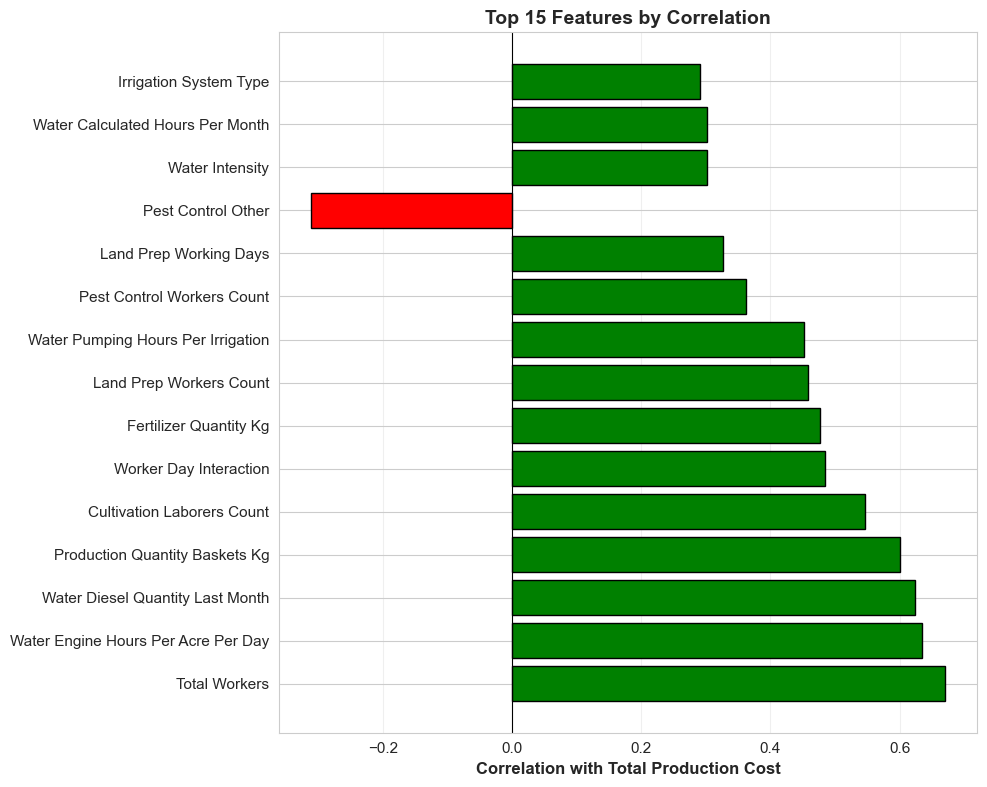

In [11]:
# Visualize top correlations
fig, ax = plt.subplots(figsize=(10, 8))

top_features = correlations.abs().sort_values(ascending=False).head(15)
colors = ['green' if x > 0 else 'red' for x in correlations[top_features.index]]

ax.barh(range(len(top_features)), correlations[top_features.index], color=colors, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels([name.replace('_', ' ').title()[:35] for name in top_features.index])
ax.set_xlabel('Correlation with Total Production Cost', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features by Correlation', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 5. Train-Test Split

In [12]:
# Separate features and target
X = df_model.drop('total_production_cost', axis=1)
y = df_model['total_production_cost']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✓ Train-Test Split Complete")
print(f"\nTraining set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"\nFeature count: {X.shape[1]}")
print(f"\nTarget variable range:")
print(f"  Training: {y_train.min():,.0f} - {y_train.max():,.0f} YER")
print(f"  Testing: {y_test.min():,.0f} - {y_test.max():,.0f} YER")

✓ Train-Test Split Complete

Training set: 24 samples
Testing set: 6 samples

Feature count: 33

Target variable range:
  Training: 108,680 - 3,824,520 YER
  Testing: 230,000 - 375,000 YER


In [13]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features scaled using StandardScaler")

✓ Features scaled using StandardScaler


## 6. Model Training

In [14]:
# Define evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Evaluate model performance with multiple metrics"""
    
    # Train predictions
    y_train_pred = model.predict(X_train)
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test predictions
    y_test_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    
    # Cross-validation (5-fold)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    
    results = {
        'Model': model_name,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Test MAPE (%)': test_mape,
        'CV R² Mean': cv_scores.mean(),
        'CV R² Std': cv_scores.std(),
        'Predictions': y_test_pred
    }
    
    return results

print("✓ Evaluation function defined")

✓ Evaluation function defined


### 6.1 Linear Regression (Baseline)

In [15]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

lr_results = evaluate_model(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, 'Linear Regression')

print("="*70)
print("LINEAR REGRESSION RESULTS")
print("="*70)
print(f"Train R²: {lr_results['Train R²']:.4f}")
print(f"Test R²: {lr_results['Test R²']:.4f}")
print(f"Test RMSE: {lr_results['Test RMSE']:,.2f} YER")
print(f"Test MAE: {lr_results['Test MAE']:,.2f} YER")
print(f"Test MAPE: {lr_results['Test MAPE (%)']:.2f}%")
print(f"CV R² (5-fold): {lr_results['CV R² Mean']:.4f} ± {lr_results['CV R² Std']:.4f}")
print("="*70)

LINEAR REGRESSION RESULTS
Train R²: 1.0000
Test R²: -1692.5373
Test RMSE: 1,980,720.38 YER
Test MAE: 1,698,729.59 YER
Test MAPE: 587.85%
CV R² (5-fold): -9.2865 ± 6.4699


### 6.2 Ridge Regression (L2 Regularization)

In [16]:
# Train Ridge Regression
ridge_model = Ridge(alpha=10.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

ridge_results = evaluate_model(ridge_model, X_train_scaled, y_train, X_test_scaled, y_test, 'Ridge Regression')

print("="*70)
print("RIDGE REGRESSION RESULTS")
print("="*70)
print(f"Train R²: {ridge_results['Train R²']:.4f}")
print(f"Test R²: {ridge_results['Test R²']:.4f}")
print(f"Test RMSE: {ridge_results['Test RMSE']:,.2f} YER")
print(f"Test MAE: {ridge_results['Test MAE']:,.2f} YER")
print(f"Test MAPE: {ridge_results['Test MAPE (%)']:.2f}%")
print(f"CV R² (5-fold): {ridge_results['CV R² Mean']:.4f} ± {ridge_results['CV R² Std']:.4f}")
print("="*70)

RIDGE REGRESSION RESULTS
Train R²: 0.8625
Test R²: -254.7261
Test RMSE: 769,685.56 YER
Test MAE: 592,678.66 YER
Test MAPE: 202.26%
CV R² (5-fold): -2.7921 ± 2.5287


### 6.3 Lasso Regression (L1 Regularization)

In [17]:
# Train Lasso Regression
lasso_model = Lasso(alpha=100.0, random_state=42, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

lasso_results = evaluate_model(lasso_model, X_train_scaled, y_train, X_test_scaled, y_test, 'Lasso Regression')

print("="*70)
print("LASSO REGRESSION RESULTS")
print("="*70)
print(f"Train R²: {lasso_results['Train R²']:.4f}")
print(f"Test R²: {lasso_results['Test R²']:.4f}")
print(f"Test RMSE: {lasso_results['Test RMSE']:,.2f} YER")
print(f"Test MAE: {lasso_results['Test MAE']:,.2f} YER")
print(f"Test MAPE: {lasso_results['Test MAPE (%)']:.2f}%")
print(f"CV R² (5-fold): {lasso_results['CV R² Mean']:.4f} ± {lasso_results['CV R² Std']:.4f}")

# Feature selection by Lasso
non_zero_features = np.sum(lasso_model.coef_ != 0)
print(f"\nFeatures selected by Lasso: {non_zero_features} out of {len(lasso_model.coef_)}")
print("="*70)

LASSO REGRESSION RESULTS
Train R²: 1.0000
Test R²: -2067.8915
Test RMSE: 2,189,246.40 YER
Test MAE: 1,781,317.98 YER
Test MAPE: 616.25%
CV R² (5-fold): -16.9969 ± 14.6661

Features selected by Lasso: 24 out of 33


### 6.4 Random Forest Regressor

In [18]:
# Train Random Forest (use unscaled data for tree-based models)
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_split=3,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

rf_results = evaluate_model(rf_model, X_train, y_train, X_test, y_test, 'Random Forest')

print("="*70)
print("RANDOM FOREST RESULTS")
print("="*70)
print(f"Train R²: {rf_results['Train R²']:.4f}")
print(f"Test R²: {rf_results['Test R²']:.4f}")
print(f"Test RMSE: {rf_results['Test RMSE']:,.2f} YER")
print(f"Test MAE: {rf_results['Test MAE']:,.2f} YER")
print(f"Test MAPE: {rf_results['Test MAPE (%)']:.2f}%")
print(f"CV R² (5-fold): {rf_results['CV R² Mean']:.4f} ± {rf_results['CV R² Std']:.4f}")
print("="*70)

RANDOM FOREST RESULTS
Train R²: 0.6404
Test R²: -1.6624
Test RMSE: 78,534.83 YER
Test MAE: 64,064.75 YER
Test MAPE: 24.84%
CV R² (5-fold): -1.1719 ± 2.5716


### 6.5 XGBoost Regressor

In [19]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

xgb_results = evaluate_model(xgb_model, X_train, y_train, X_test, y_test, 'XGBoost')

print("="*70)
print("XGBOOST RESULTS")
print("="*70)
print(f"Train R²: {xgb_results['Train R²']:.4f}")
print(f"Test R²: {xgb_results['Test R²']:.4f}")
print(f"Test RMSE: {xgb_results['Test RMSE']:,.2f} YER")
print(f"Test MAE: {xgb_results['Test MAE']:,.2f} YER")
print(f"Test MAPE: {xgb_results['Test MAPE (%)']:.2f}%")
print(f"CV R² (5-fold): {xgb_results['CV R² Mean']:.4f} ± {xgb_results['CV R² Std']:.4f}")
print("="*70)

NameError: name 'xgb' is not defined

## 7. Model Comparison

In [21]:
# Compile all results
all_results = [lr_results, ridge_results, lasso_results, rf_results]

comparison_df = pd.DataFrame([
    {
        'Model': r['Model'],
        'Test R²': r['Test R²'],
        'Test RMSE': r['Test RMSE'],
        'Test MAE': r['Test MAE'],
        'Test MAPE (%)': r['Test MAPE (%)'],
        'CV R² Mean': r['CV R² Mean'],
        'CV R² Std': r['CV R² Std'],
        'Overfit Gap': r['Train R²'] - r['Test R²']
    }
    for r in all_results
])

# Sort by Test R²
comparison_df = comparison_df.sort_values('Test R²', ascending=False)

print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY")
print("="*100)
display(comparison_df.style.format({
    'Test R²': '{:.4f}',
    'Test RMSE': '{:,.2f}',
    'Test MAE': '{:,.2f}',
    'Test MAPE (%)': '{:.2f}',
    'CV R² Mean': '{:.4f}',
    'CV R² Std': '{:.4f}',
    'Overfit Gap': '{:.4f}'
}).background_gradient(subset=['Test R²'], cmap='RdYlGn'))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_r2 = comparison_df.iloc[0]['Test R²']
print(f"\n✓ Best Model: {best_model_name} (Test R² = {best_r2:.4f})")


MODEL COMPARISON SUMMARY


,Model,Test R²,Test RMSE,Test MAE,Test MAPE (%),CV R² Mean,CV R² Std,Overfit Gap
3,Random Forest,-1.6624,"78,534.83","64,064.75",24.84,-1.1719,2.5716,2.3028
1,Ridge Regression,-254.7261,"769,685.56","592,678.66",202.26,-2.7921,2.5287,255.5886
0,Linear Regression,-1692.5373,"1,980,720.38","1,698,729.59",587.85,-9.2865,6.4699,1693.5373
2,Lasso Regression,-2067.8915,"2,189,246.40","1,781,317.98",616.25,-16.9969,14.6661,2068.8915



✓ Best Model: Random Forest (Test R² = -1.6624)


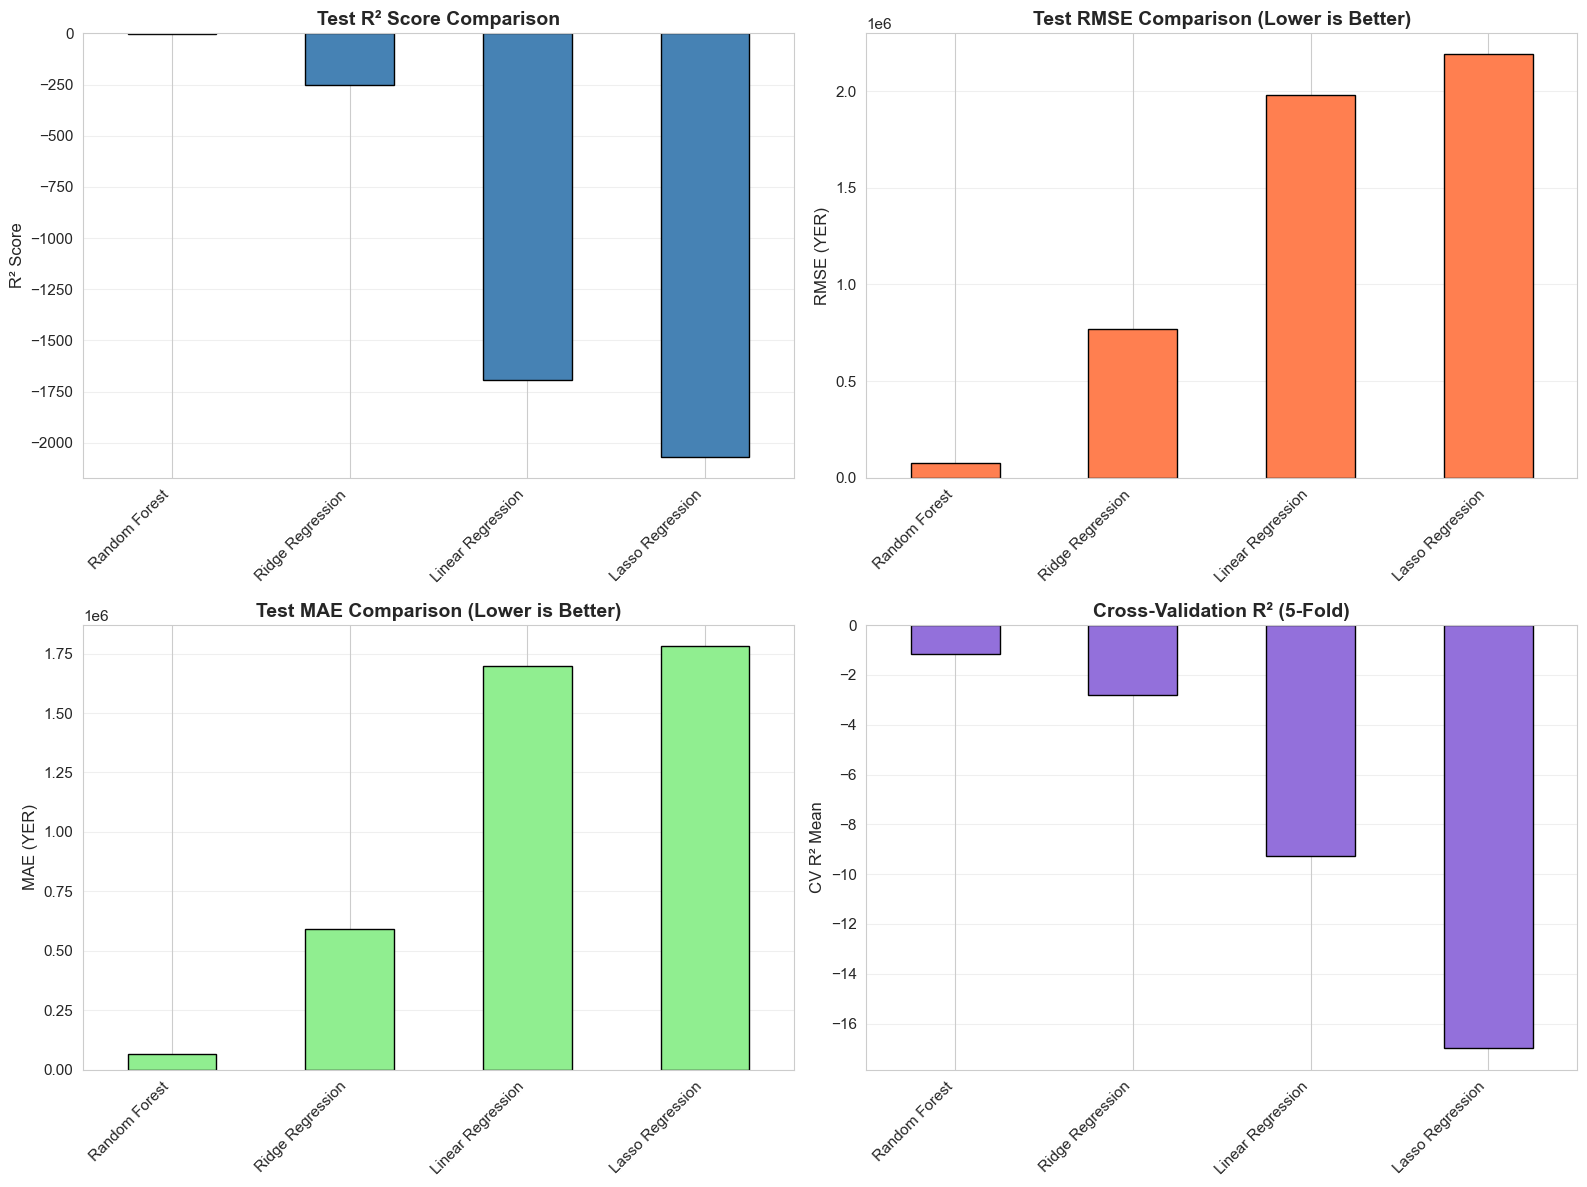

In [22]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test R² comparison
ax1 = axes[0, 0]
comparison_df.plot(x='Model', y='Test R²', kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('Test R² Score Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_xlabel('')
ax1.grid(True, alpha=0.3, axis='y')
ax1.legend().set_visible(False)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# RMSE comparison
ax2 = axes[0, 1]
comparison_df.plot(x='Model', y='Test RMSE', kind='bar', ax=ax2, color='coral', edgecolor='black')
ax2.set_title('Test RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax2.set_ylabel('RMSE (YER)', fontsize=12)
ax2.set_xlabel('')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend().set_visible(False)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# MAE comparison
ax3 = axes[1, 0]
comparison_df.plot(x='Model', y='Test MAE', kind='bar', ax=ax3, color='lightgreen', edgecolor='black')
ax3.set_title('Test MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax3.set_ylabel('MAE (YER)', fontsize=12)
ax3.set_xlabel('')
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend().set_visible(False)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Cross-validation scores
ax4 = axes[1, 1]
comparison_df.plot(x='Model', y='CV R² Mean', kind='bar', ax=ax4, 
                  yerr=comparison_df['CV R² Std'], capsize=5,
                  color='mediumpurple', edgecolor='black',
                  error_kw={'linewidth': 2})
ax4.set_title('Cross-Validation R² (5-Fold)', fontsize=14, fontweight='bold')
ax4.set_ylabel('CV R² Mean', fontsize=12)
ax4.set_xlabel('')
ax4.grid(True, alpha=0.3, axis='y')
ax4.legend().set_visible(False)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

In [23]:
# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRANDOM FOREST - Top 15 Important Features:")
print("="*60)
for idx, row in rf_importance.head(15).iterrows():
    print(f"{row['Feature']:40s}: {row['Importance']:.4f}")


RANDOM FOREST - Top 15 Important Features:
production_quantity_baskets_kg          : 0.3957
water_diesel_quantity_last_month        : 0.2436
water_intensity                         : 0.0554
water_calculated_hours_per_month        : 0.0473
worker_day_interaction                  : 0.0407
water_meter_reading                     : 0.0392
total_workers                           : 0.0371
water_engine_hours_per_acre_per_day     : 0.0285
fertilizer_quantity_kg                  : 0.0225
land_prep_workers_count                 : 0.0169
pest_control_worker_wage_per_day        : 0.0121
water_irrigation_frequency_per_month    : 0.0116
pest_control_working_days               : 0.0094
water_pumping_hours_per_irrigation      : 0.0092
land_prep_working_days                  : 0.0088


In [ ]:
# XGBoost Feature Importance
#xgb_importance = pd.DataFrame({
#    'Feature': X_train.columns,
 #   'Importance': xgb_model.feature_importances_
#}).sort_values('Importance', ascending=False)

#print("\nXGBOOST - Top 15 Important Features:")
#print("="*60)
#for idx, row in xgb_importance.head(15).iterrows():
#    print(f"{row['Feature']:40s}: {row['Importance']:.4f}")

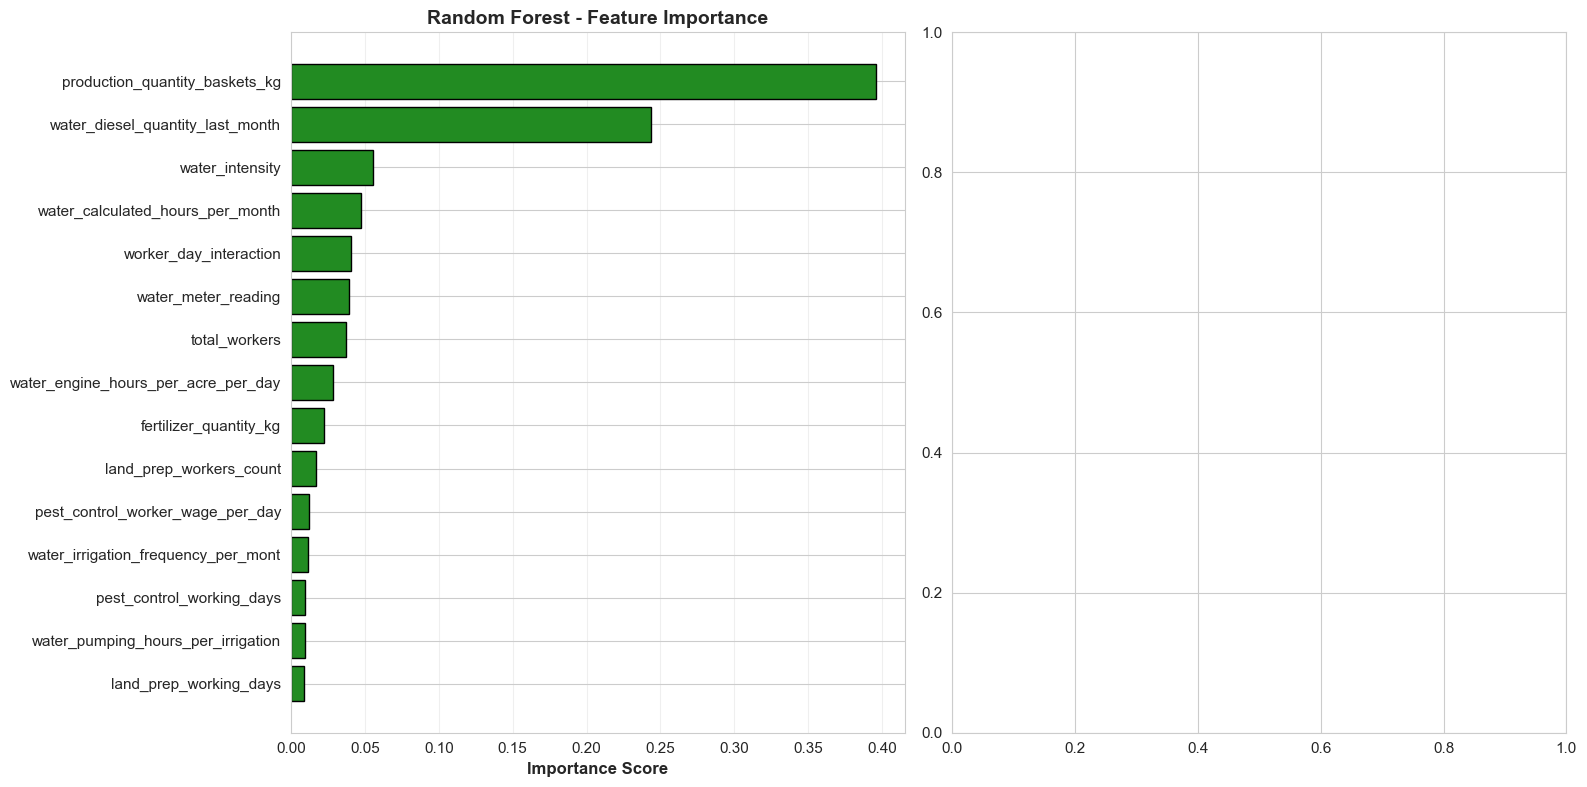

In [25]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest
ax1 = axes[0]
top_rf = rf_importance.head(15)
ax1.barh(range(len(top_rf)), top_rf['Importance'], color='forestgreen', edgecolor='black')
ax1.set_yticks(range(len(top_rf)))
ax1.set_yticklabels([name[:35] for name in top_rf['Feature']])
ax1.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax1.set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')
ax1.invert_yaxis()


plt.tight_layout()
plt.show()

## 9. Prediction Visualization

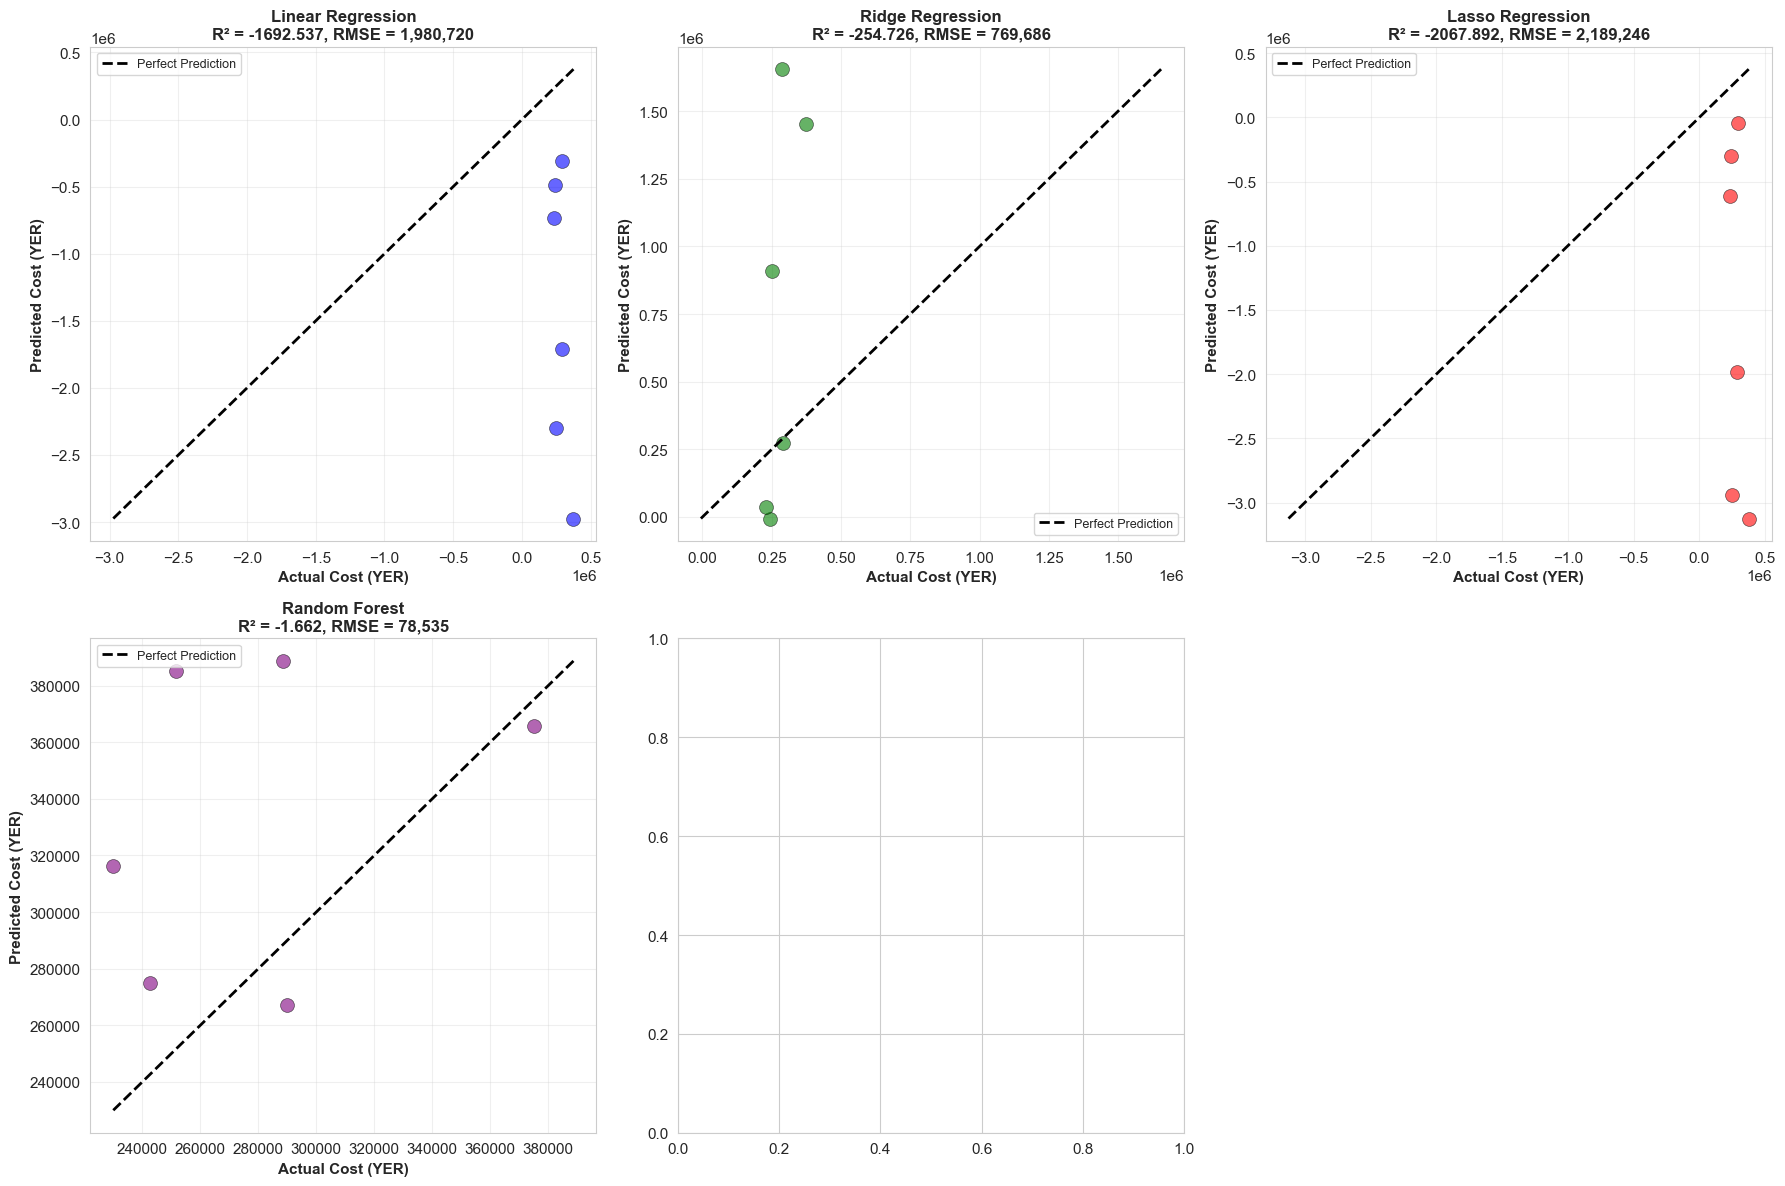

In [26]:
# Actual vs Predicted plots for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (result, color) in enumerate(zip(all_results, 
                                          ['blue', 'green', 'red', 'purple', 'orange'])):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(y_test, result['Predictions'], alpha=0.6, s=100, 
              color=color, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_test.min(), result['Predictions'].min())
    max_val = max(y_test.max(), result['Predictions'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect Prediction')
    
    # Labels and title
    ax.set_xlabel('Actual Cost (YER)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Cost (YER)', fontsize=11, fontweight='bold')
    ax.set_title(f"{result['Model']}\nR² = {result['Test R²']:.3f}, RMSE = {result['Test RMSE']:,.0f}", 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

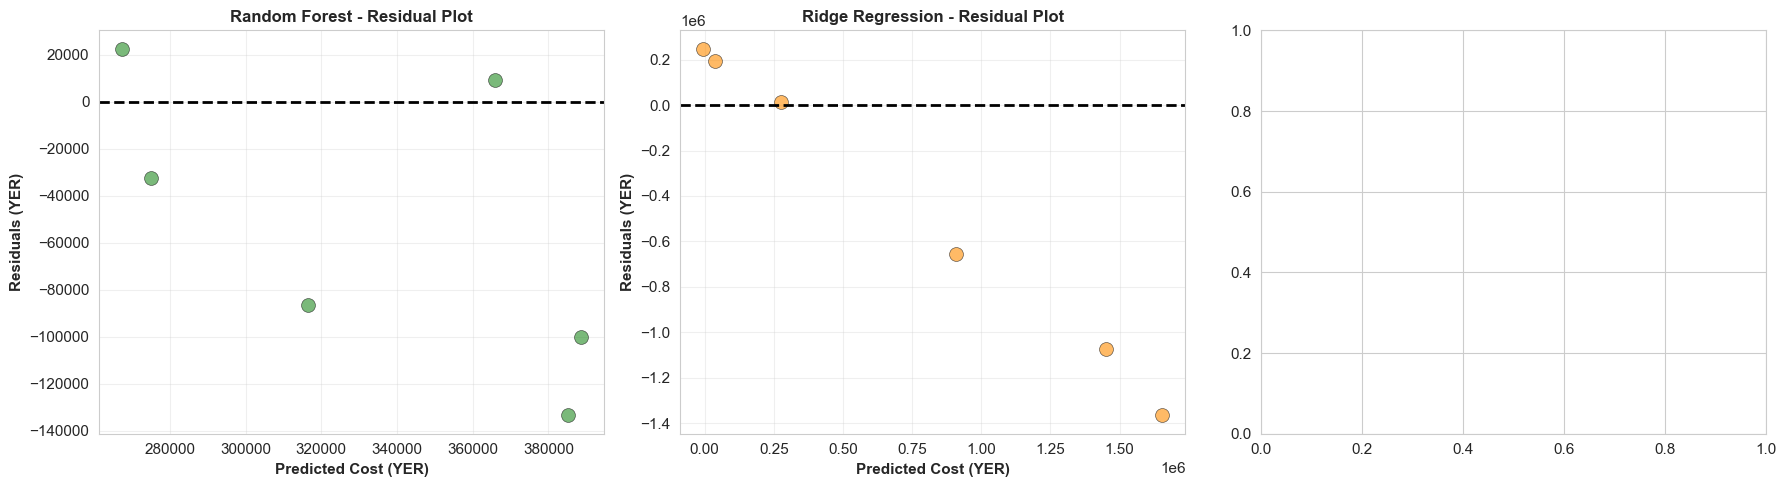

In [28]:
# Residual plots for best models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_to_plot = [rf_results, ridge_results]
colors = ['forestgreen', 'darkorange', 'steelblue']

for idx, (result, color) in enumerate(zip(models_to_plot, colors)):
    ax = axes[idx]
    
    residuals = y_test - result['Predictions']
    
    ax.scatter(result['Predictions'], residuals, alpha=0.6, s=100,
              color=color, edgecolors='black', linewidth=0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Predicted Cost (YER)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Residuals (YER)', fontsize=11, fontweight='bold')
    ax.set_title(f'{result["Model"]} - Residual Plot', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Prediction Examples

In [29]:
# Show prediction examples from test set
print("\n" + "="*100)
print("SAMPLE PREDICTIONS (Best Model: Random Forest)")
print("="*100)

# Select best model predictions
best_predictions = rf_results['Predictions']

# Create comparison dataframe
prediction_comparison = pd.DataFrame({
    'Actual Cost (YER)': y_test.values,
    'Predicted Cost (YER)': best_predictions,
    'Error (YER)': y_test.values - best_predictions,
    'Error (%)': ((y_test.values - best_predictions) / y_test.values * 100)
}, index=y_test.index)

print("\nFirst 10 Test Samples:")
display(prediction_comparison.head(10).style.format({
    'Actual Cost (YER)': '{:,.2f}',
    'Predicted Cost (YER)': '{:,.2f}',
    'Error (YER)': '{:+,.2f}',
    'Error (%)': '{:+.2f}'
}))

print(f"\nMean Absolute Error: {prediction_comparison['Error (YER)'].abs().mean():,.2f} YER")
print(f"Mean Percentage Error: {prediction_comparison['Error (%)'].abs().mean():.2f}%")


SAMPLE PREDICTIONS (Best Model: Random Forest)

First 10 Test Samples:


,Actual Cost (YER),Predicted Cost (YER),Error (YER),Error (%)
27,"242,680.00","274,963.90","-32,283.90",-13.30
15,"230,000.00","316,414.51","-86,414.51",-37.57
23,"290,000.00","267,349.73","+22,650.27",+7.81
17,"251,500.00","385,061.06","-133,561.06",-53.11
8,"288,400.00","388,703.68","-100,303.68",-34.78
9,"375,000.00","365,824.89","+9,175.11",+2.45



Mean Absolute Error: 64,064.75 YER
Mean Percentage Error: 24.84%


## 11. Key Insights & Recommendations

In [31]:
print("="*100)
print("KEY INSIGHTS FROM PREDICTIVE MODELING")
print("="*100)

# Best model
best_idx = comparison_df['Test R²'].idxmax()
best_model_info = comparison_df.loc[best_idx]

print(f"\n1. BEST PERFORMING MODEL: {best_model_info['Model']}")
print(f"   • Test R²: {best_model_info['Test R²']:.4f} (explains {best_model_info['Test R²']*100:.2f}% of variance)")
print(f"   • Test RMSE: {best_model_info['Test RMSE']:,.2f} YER")
print(f"   • Test MAE: {best_model_info['Test MAE']:,.2f} YER")
print(f"   • Test MAPE: {best_model_info['Test MAPE (%)']:.2f}%")
print(f"   • Cross-validation: {best_model_info['CV R² Mean']:.4f} ± {best_model_info['CV R² Std']:.4f}")

# Top features
print(f"\n2. TOP 5 MOST IMPORTANT FEATURES (Random Forest):")
for idx, row in rf_importance.head(5).iterrows():
    print(f"   • {row['Feature']}: {row['Importance']:.4f}")

print(f"\n3. TOP 5 MOST IMPORTANT FEATURES (XGBoost):")


# Model stability
print(f"\n4. MODEL STABILITY (Cross-Validation):")
for _, row in comparison_df.iterrows():
    stability = "High" if row['CV R² Std'] < 0.1 else "Medium" if row['CV R² Std'] < 0.2 else "Low"
    print(f"   • {row['Model']:20s}: CV Std = {row['CV R² Std']:.4f} ({stability} stability)")

# Overfitting check
print(f"\n5. OVERFITTING ANALYSIS:")
for _, row in comparison_df.iterrows():
    overfit_status = "Good" if row['Overfit Gap'] < 0.1 else "Moderate" if row['Overfit Gap'] < 0.2 else "High"
    print(f"   • {row['Model']:20s}: Train-Test Gap = {row['Overfit Gap']:+.4f} ({overfit_status})")

print("\n" + "="*100)
print("RECOMMENDATIONS")
print("="*100)
print(f"\n✓ Use {best_model_info['Model']} for production cost predictions")
print(f"✓ Focus on optimizing top features to reduce costs effectively")
print(f"✓ Expected prediction accuracy: ±{best_model_info['Test MAPE (%)']:.1f}% on average")
print(f"✓ Model performs best with complete farm characteristic data")
print("\n" + "="*100)

KEY INSIGHTS FROM PREDICTIVE MODELING

1. BEST PERFORMING MODEL: Random Forest
   • Test R²: -1.6624 (explains -166.24% of variance)
   • Test RMSE: 78,534.83 YER
   • Test MAE: 64,064.75 YER
   • Test MAPE: 24.84%
   • Cross-validation: -1.1719 ± 2.5716

2. TOP 5 MOST IMPORTANT FEATURES (Random Forest):
   • production_quantity_baskets_kg: 0.3957
   • water_diesel_quantity_last_month: 0.2436
   • water_intensity: 0.0554
   • water_calculated_hours_per_month: 0.0473
   • worker_day_interaction: 0.0407

3. TOP 5 MOST IMPORTANT FEATURES (XGBoost):

4. MODEL STABILITY (Cross-Validation):
   • Random Forest       : CV Std = 2.5716 (Low stability)
   • Ridge Regression    : CV Std = 2.5287 (Low stability)
   • Linear Regression   : CV Std = 6.4699 (Low stability)
   • Lasso Regression    : CV Std = 14.6661 (Low stability)

5. OVERFITTING ANALYSIS:
   • Random Forest       : Train-Test Gap = +2.3028 (High)
   • Ridge Regression    : Train-Test Gap = +255.5886 (High)
   • Linear Regression   

## 12. Export Results

In [32]:
# Export model comparison
comparison_df.to_excel('Model_Comparison_Results.xlsx', index=False)
print("✓ Model comparison exported to: Model_Comparison_Results.xlsx")

# Export feature importance
with pd.ExcelWriter('Feature_Importance_Results.xlsx') as writer:
    rf_importance.to_excel(writer, sheet_name='Random Forest', index=False)

print("✓ Feature importance exported to: Feature_Importance_Results.xlsx")

# Export predictions
prediction_comparison.to_excel('Cost_Predictions.xlsx')
print("✓ Predictions exported to: Cost_Predictions.xlsx")

✓ Model comparison exported to: Model_Comparison_Results.xlsx
✓ Feature importance exported to: Feature_Importance_Results.xlsx
✓ Predictions exported to: Cost_Predictions.xlsx
